<a href="https://colab.research.google.com/github/rajkhatana/Khatana/blob/master/LSTM_ppt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> LONG SHORT-TERM MEMORY( LSTM ) </center>
## <center> Prof. Laxmidhar Behera </center>
## <center>IIT Kanpur </center>


<img src = "https://drive.google.com/uc?id=1Jr-6cJ0yvIdj3kD-5qXpFvfQikAylXLI">

<img src="https://drive.google.com/uc?id=1op7uUppbnuUaPjaaVnlN92STIsyImxzE">

<img src="https://drive.google.com/uc?id=1rP1hOgMIbTlIOsnZ9sV98i7INR8OXf8Q">

<img src="https://drive.google.com/uc?id=1P9wsko819-KheixCqViTYX1-FD1BAkxw">

<img src="https://drive.google.com/uc?id=1cCYwcL2y861bH5jB4mEX-Bizp4bCYzc6">

<img src="https://drive.google.com/uc?id=1U7MyqKYPrnllfCY2jQUryVzGsrZ3bpkD">

<img src="https://drive.google.com/uc?id=1ngeR2e1SonERKDqJ7W5Fj1UO_xaqFSrK">

<img src="https://drive.google.com/uc?id=1ugwD7LX4Wclpz_jOfQe0IRX0YKU6pIRb">

<img src="https://drive.google.com/uc?id=138hbXBBjwipy8og2IEPRQIO_3UZqN6a6">

<img src="https://drive.google.com/uc?id=1yzjDuB8TDosG3HJiZwrLbYSlQg1wbgtF">

<img src="https://drive.google.com/uc?id=1Qe5MG4lY6KtDPbyNM7Vfd_3IaHHB1DJg">

<img src="https://drive.google.com/uc?id=1ItRk-47fp8Pq9g4cuKd1cXBz4PNnAV_b">

<img src="https://drive.google.com/uc?id=1NybpdnlsIRE_el9vCV8CQxy7bw5m5xWE">

##  LSTM EXAMPLE CODE	

<b>Problem</b>: Download NIFTY50 data from 19/06/18 to 18/06/19 from www.nseindia.com . Use the turnover(in crores) data from 19/06/18 to 18/04/19 as train data and from 19/04/19 to 19/06/19  as test data. <br>
---- Take timesteps = 30, i.e, take first 30 days of data as input to predict the turnover on the 31st day.





In [0]:
#Importing Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed,Input


In [0]:
### Download data from google drive. You need not mess with this code.

import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
if __name__ == "__main__":
    file_id = '1zwOzXasF6Zs92HtIhj_4tSFeuwTqD6M5'
    destination = 'nse50_data.csv'
    download_file_from_google_drive(file_id, destination)

In [27]:
# reading the data from data file
df = pd.read_csv('nse50_data.csv')
print(df[:5])


          Date      Open      High  ...     Close  Shares Traded  Turnover (Rs. Cr)
0  19-Jun-2018  10789.45  10789.45  ...  10710.45      231382790           12290.16
1  20-Jun-2018  10734.65  10781.80  ...  10772.05      199467082           10858.35
2  21-Jun-2018  10808.45  10809.60  ...  10741.10      230507383           12211.18
3  22-Jun-2018  10742.70  10837.00  ...  10821.85      236898415           13520.01
4  25-Jun-2018  10822.90  10831.05  ...  10762.45      236693278           12012.41

[5 rows x 7 columns]


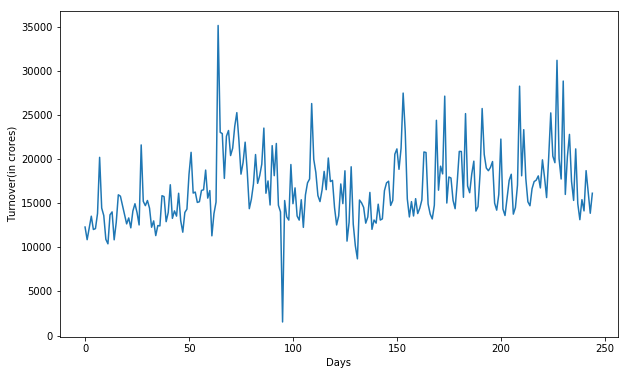

In [28]:
# plotting the turnover values
data = df.iloc[:,6].values
plt.figure(figsize=(10, 6))
plt.xlabel('Days')
plt.ylabel('Turnover(in crores)')
plt.plot(data)

In [29]:
# Divide into train and test data
df['Date'] = pd.to_datetime(df['Date'])  
mask = (df['Date'] == '2019-4-18')
print(df.loc[mask])     # index for the date 18-Apr-2019
print('--------------------------------------------')
train = data[:205]
test = data[175:]
# print(train)

          Date      Open      High  ...    Close  Shares Traded  Turnover (Rs. Cr)
205 2019-04-18  11856.15  11856.15  ...  11752.8      339653709           18271.27

[1 rows x 7 columns]
--------------------------------------------


In [0]:
# Normalize the train and test data using min-max scaler
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train.reshape(-1,1))
test = sc.transform(test.reshape(-1,1))


In [0]:
#Create X_train using 30 timesteps for each sample
X_train = []
y_train = []
for i in range(30, train.shape[0]):
    X_train.append(train[i-30:i, 0])
    y_train.append(train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)



In [32]:
print(X_train.shape, y_train.shape)
print(X_train)
print(y_train[:2])

(175, 30) (175,)
[[0.32014897 0.27753191 0.31779817 ... 0.59711237 0.40685077 0.39237244]
 [0.27753191 0.31779817 0.35675479 ... 0.40685077 0.39237244 0.40965785]
 [0.31779817 0.35675479 0.31188189 ... 0.39237244 0.40965785 0.38402232]
 ...
 [0.49944087 0.76165063 0.40110533 ... 0.43010574 0.61685008 0.38092919]
 [0.76165063 0.40110533 0.48890961 ... 0.61685008 0.38092919 0.35909428]
 [0.40110533 0.48890961 0.48566231 ... 0.38092919 0.35909428 0.41972985]]
[0.40965785 0.38402232]


In [39]:
# Training LSTM model

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
lstm_model = Sequential()
lstm_model.add(LSTM(8, input_shape=(X_train.shape[1], 1), activation='relu',kernel_initializer='lecun_uniform'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

lstm_model.fit(X_train, y_train, epochs = 100, batch_size = 4)


Epoch 1/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0764
Epoch 2/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0153
Epoch 3/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0144
Epoch 4/100
175/175 [==============================] - 1s 3ms/step - loss: 0.0135
Epoch 5/100
175/175 [==============================] - 1s 3ms/step - loss: 0.0130
Epoch 6/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0128
Epoch 7/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0123
Epoch 8/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0124
Epoch 9/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0120
Epoch 10/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0117
Epoch 11/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0116
Epoch 12/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0115
Epoch 13/100


In [40]:
# Create X_test using 30 timesteps for each sample
X_test = []
y_test = []

for i in range(30, test.shape[0]):
    X_test.append(test[i-30:i, 0])
    y_test.append(test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)

(40, 30)
(175, 30, 1)


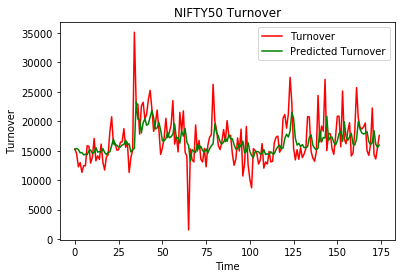

In [41]:
# plot predictions vs real turnover on training set
predicted = lstm_model.predict(X_train)
predicted = sc.inverse_transform(predicted)
plt.plot(sc.inverse_transform(train[-175:]), color = 'red', label = 'Turnover')
plt.plot(predicted, color = 'green', label = 'Predicted Turnover')
plt.title('NIFTY50 Turnover')
plt.xlabel('Time')
plt.ylabel('Turnover')
plt.legend()
plt.show()

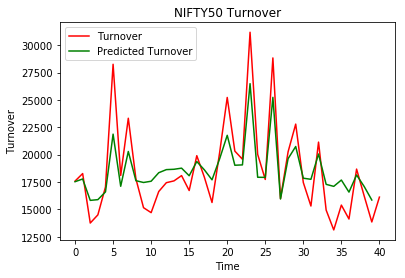

In [36]:
# plotting predictions vs true turnover for the test set
predicted = lstm_model.predict(X_test)
predicted = sc.inverse_transform(predicted)
plt.plot(sc.inverse_transform(test[-41:]), color = 'red', label = 'Turnover')
plt.plot(predicted, color = 'green', label = 'Predicted Turnover')
plt.title('NIFTY50 Turnover')
plt.xlabel('Time')
plt.ylabel('Turnover')
plt.legend()
plt.show()

<img src="https://drive.google.com/uc?id=1NtkoNI1RlhQZKfHGG-9cx7_ViI_JbnlL">

<img src="https://drive.google.com/uc?id=1GkY3hiRKYXDKHrVHYm9dY0hCbaUJqrlo">